In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

c = c.split('stop')[0]

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =0

nband = 520

ng =8

ng_adju = (/ 0 , -1 /) 

ng_refs = (/ 3 , 2 , 3 /) 

nref =3

nv = 1000

option_compute_btable =0

option_compute_ktable =0

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =257

vstar = 1380

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66/

data wgt
     &     /0.55 , 0.55 , 0.85 , 0.85,
     &     0.85 , 0.0 , 0.3 , 0.55/

atmosphere_profiles/saw75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

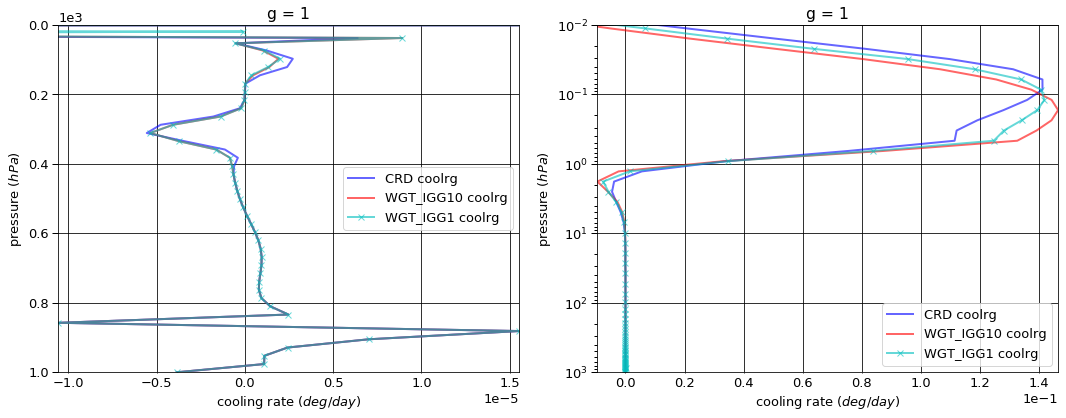

# Figure: cooling rate g-group 2

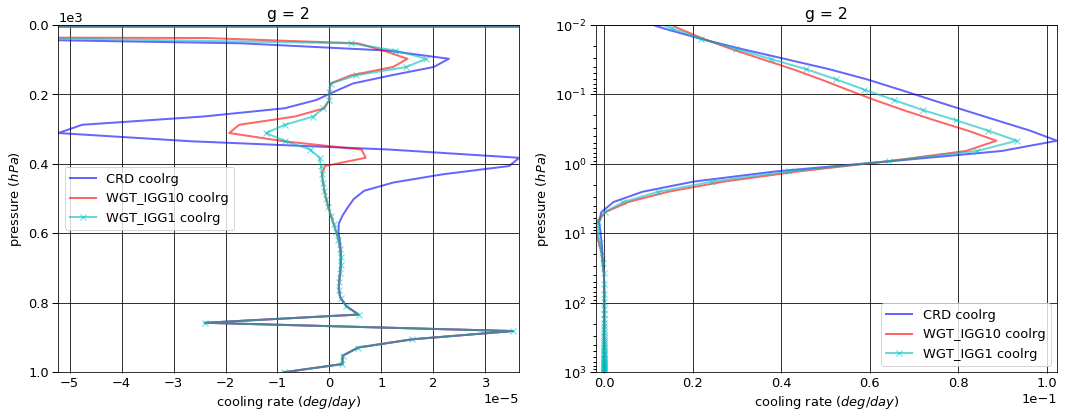

# Figure: cooling rate g-group 3

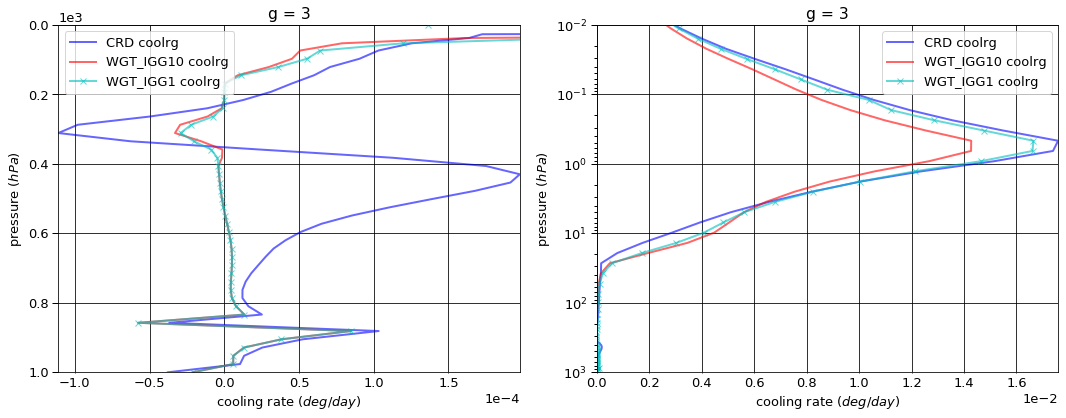

# Figure: cooling rate g-group 4

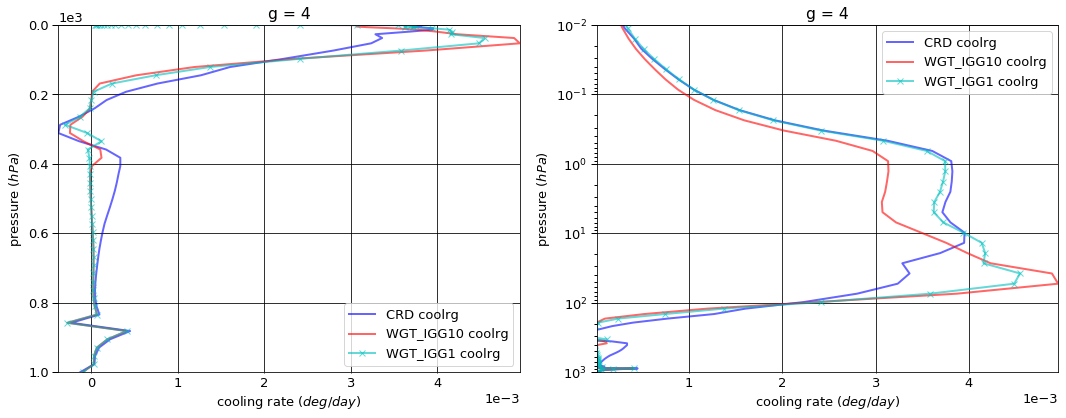

# Figure: cooling rate g-group 5

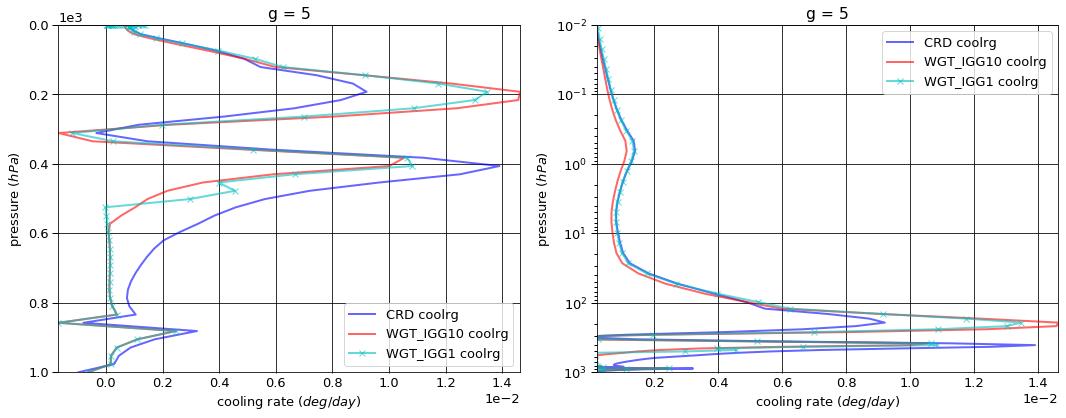

# Figure: cooling rate g-group 6

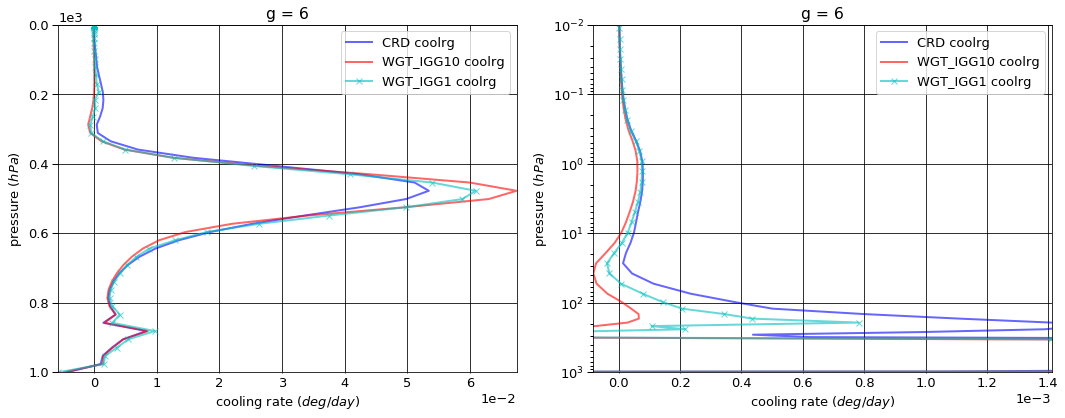

# Figure: cooling rate g-group 7

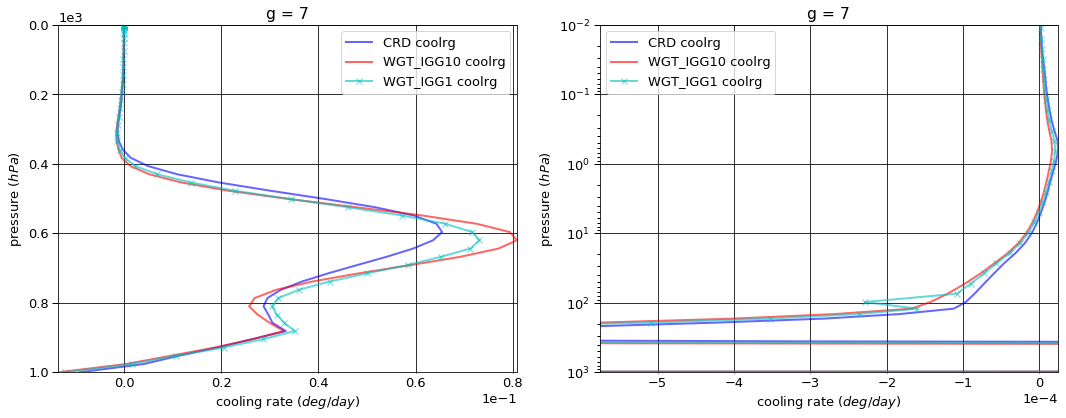

# Figure: cooling rate g-group 8

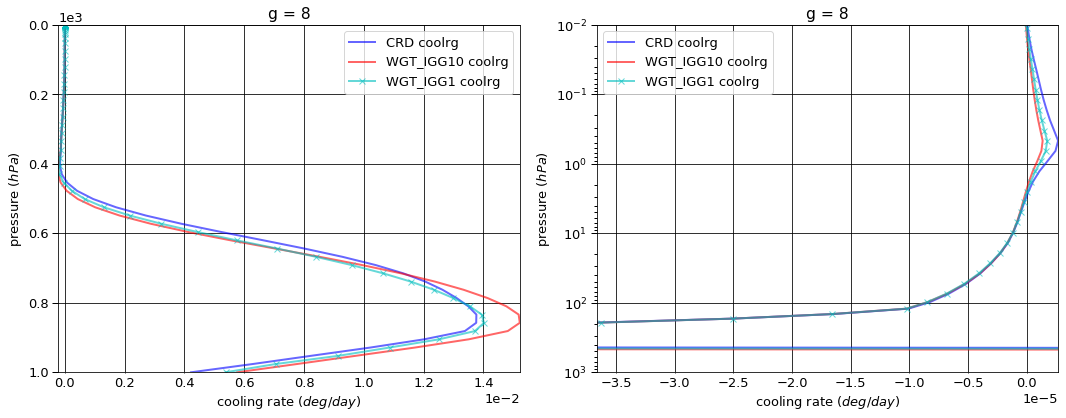

# Figure: cooling rate g-group total

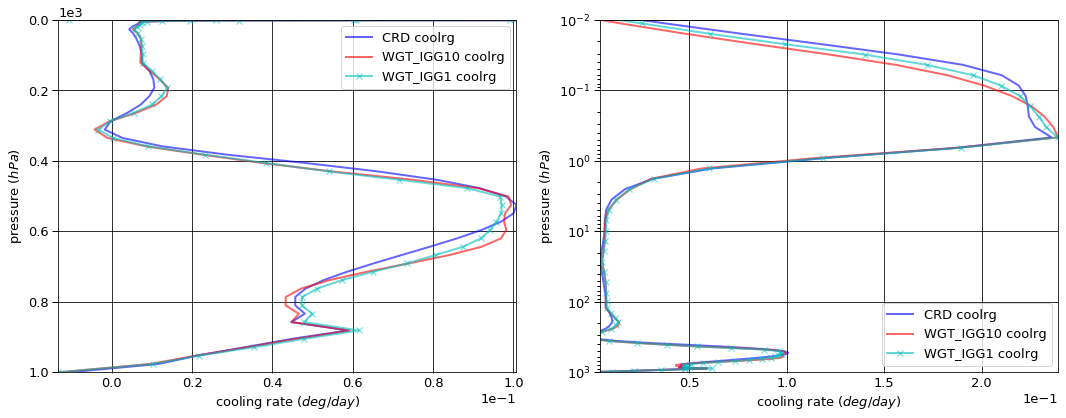

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.009031  0.000000 -0.009031
  1013.0   76    -0.011429  0.011442  0.000013
2 0.0      1     -0.013087  0.000000 -0.013087
  1013.0   76    -0.026030  0.026060  0.000030
3 0.0      1     -0.015226  0.000000 -0.015226
  1013.0   76    -0.062332  0.062474  0.000142
4 0.0      1     -0.058884  0.000000 -0.058884
  1013.0   76    -0.300919  0.301408  0.000489
5 0.0      1     -0.452884  0.000000 -0.452884
  1013.0   76    -1.821329  1.825139  0.003810
6 0.0      1     -1.252731  0.000000 -1.252731
  1013.0   76    -3.310379  3.326011  0.015632
7 0.0      1     -2.416739  0.000000 -2.416739
  1013.0   76    -3.892652  3.955502  0.062850
8 0.0      1     -0.658276  0.000000 -0.658276
  1013.0   76    -0.756372  0.640347 -0.116024


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.009614  0.000000 -0.009614
  1013.0   76    -0.011429  0.011442  0.000013
2 0.0      1     -0.012945  0.000000 -0.012945
  1013.0   76    -0.026030  0.026060  0.000030
3 0.0      1     -0.013327  0.000000 -0.013327
  1013.0   76    -0.062332  0.062404  0.000072
4 0.0      1     -0.054379  0.000000 -0.054379
  1013.0   76    -0.300919  0.301265  0.000346
5 0.0      1     -0.373159  0.000000 -0.373159
  1013.0   76    -1.821329  1.823417  0.002089
6 0.0      1     -1.277299  0.000000 -1.277299
  1013.0   76    -3.310379  3.326957  0.016578
7 0.0      1     -2.472360  0.000000 -2.472360
  1013.0   76    -3.892652  3.989921  0.097270
8 0.0      1     -0.674069  0.000000 -0.674069
  1013.0   76    -0.756372  0.643662 -0.112709


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.009423  0.000000 -0.009423
  1013.0   76    -0.011429  0.011442  0.000013
2 0.0      1     -0.012964  0.000000 -0.012964
  1013.0   76    -0.026030  0.026060  0.000030
3 0.0      1     -0.013613  0.000000 -0.013613
  1013.0   76    -0.062332  0.062404  0.000072
4 0.0      1     -0.054767  0.000000 -0.054767
  1013.0   76    -0.300919  0.301265  0.000346
5 0.0      1     -0.377594  0.000000 -0.377594
  1013.0   76    -1.821329  1.823417  0.002089
6 0.0      1     -1.288716  0.000000 -1.288716
  1013.0   76    -3.310379  3.330436  0.020057
7 0.0      1     -2.487780  0.000000 -2.487780
  1013.0   76    -3.892652  3.990966  0.098314
8 0.0      1     -0.668869  0.000000 -0.668869
  1013.0   76    -0.756372  0.620409 -0.135962


WGT_IGG10 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -5.830940e-04  0.000000e+00 -5.830940e-04
  1013.0   76     0.000000e+00  0.000000e+00 -1.694066e-21
2 0.0      1      1.422290e-04  0.000000e+00  1.422290e-04
  1013.0   76     0.000000e+00 -2.120000e-07 -2.117960e-07
3 0.0      1      1.899444e-03  0.000000e+00  1.899444e-03
  1013.0   76     0.000000e+00 -7.066200e-05 -7.066224e-05
4 0.0      1      4.505296e-03  0.000000e+00  4.505296e-03
  1013.0   76     0.000000e+00 -1.433400e-04 -1.433403e-04
5 0.0      1      7.972541e-02  0.000000e+00  7.972541e-02
  1013.0   76     2.220446e-16 -1.721100e-03 -1.721048e-03
6 0.0      1     -2.456830e-02  0.000000e+00 -2.456830e-02
  1013.0   76     0.000000e+00  9.458000e-04  9.457420e-04
7 0.0      1     -5.562110e-02  0.000000e+00 -5.562110e-02
  1013.0   76     0.000000e+00  3.441920e-02  3.441925e-02
8 0.0      1     -1.579285e-02  0.000000e+00 -1.579285e-02
  1013.0   76     0.000000e+00  3.314950e-03  3.314950e-03


WGT_IGG1 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -3.919965e-04  0.000000e+00 -3.919965e-04
  1013.0   76     0.000000e+00  0.000000e+00 -1.694066e-21
2 0.0      1      1.229640e-04  0.000000e+00  1.229640e-04
  1013.0   76     0.000000e+00 -2.120000e-07 -2.117960e-07
3 0.0      1      1.612926e-03  0.000000e+00  1.612926e-03
  1013.0   76     0.000000e+00 -7.066200e-05 -7.066224e-05
4 0.0      1      4.117318e-03  0.000000e+00  4.117318e-03
  1013.0   76     0.000000e+00 -1.433400e-04 -1.433403e-04
5 0.0      1      7.529007e-02  0.000000e+00  7.529007e-02
  1013.0   76     2.220446e-16 -1.721100e-03 -1.721048e-03
6 0.0      1     -3.598500e-02  0.000000e+00 -3.598500e-02
  1013.0   76     0.000000e+00  4.425000e-03  4.424973e-03
7 0.0      1     -7.104120e-02  0.000000e+00 -7.104120e-02
  1013.0   76     0.000000e+00  3.546360e-02  3.546360e-02
8 0.0      1     -1.059300e-02  0.000000e+00 -1.059300e-02
  1013.0   76     0.000000e+00 -1.993782e-02 -1.993782e-02

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.777749e-01
  1001.112500 75    -3.864443e-06
2 0.000312    1     -2.253889e-02
  1001.112500 75    -8.831795e-06
3 0.000312    1     -4.650457e-05
  1001.112500 75    -3.777148e-05
4 0.000312    1      4.762607e-07
  1001.112500 75    -1.311237e-04
5 0.000312    1     -2.623242e-05
  1001.112500 75    -9.718269e-04
6 0.000312    1     -1.376464e-07
  1001.112500 75    -4.336168e-03
7 0.000312    1     -1.010048e-06
  1001.112500 75    -9.263194e-03
8 0.000312    1     -3.752427e-07
  1001.112500 75     4.218833e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.542795e-01
  1001.112500 75    -3.864443e-06
2 0.000312    1     -7.300867e-03
  1001.112500 75    -8.775581e-06
3 0.000312    1      2.642079e-04
  1001.112500 75    -2.108721e-05
4 0.000312    1      3.658994e-05
  1001.112500 75    -1.016589e-04
5 0.000312    1      2.512461e-05
  1001.112500 75    -6.142615e-04
6 0.000312    1     -1.785732e-07
  1001.112500 75    -4.759042e-03
7 0.000312    1     -9.225803e-07
  1001.112500 75    -1.357235e-02
8 0.000312    1     -3.034490e-07
  1001.112500 75     5.761378e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.598105e-01
  1001.112500 75    -3.864443e-06
2 0.000312    1     -1.811111e-02
  1001.112500 75    -8.775581e-06
3 0.000312    1      1.363866e-04
  1001.112500 75    -2.108721e-05
4 0.000312    1      4.231796e-05
  1001.112500 75    -1.016589e-04
5 0.000312    1      3.097327e-05
  1001.112500 75    -6.142615e-04
6 0.000312    1     -1.193730e-07
  1001.112500 75    -5.683726e-03
7 0.000312    1     -8.928121e-07
  1001.112500 75    -1.222916e-02
8 0.000312    1     -3.126562e-07
  1001.112500 75     5.372478e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.349536e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      1.523802e-02
  1001.112500 75     5.621420e-08
3 0.000312    1      3.107125e-04
  1001.112500 75     1.668427e-05
4 0.000312    1      3.611368e-05
  1001.112500 75     2.946479e-05
5 0.000312    1      5.135703e-05
  1001.112500 75     3.575654e-04
6 0.000312    1     -4.092678e-08
  1001.112500 75    -4.228739e-04
7 0.000312    1      8.746741e-08
  1001.112500 75    -4.309159e-03
8 0.000312    1      7.179373e-08
  1001.112500 75     1.542544e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.796436e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      4.427785e-03
  1001.112500 75     5.621420e-08
3 0.000312    1      1.828912e-04
  1001.112500 75     1.668427e-05
4 0.000312    1      4.184170e-05
  1001.112500 75     2.946479e-05
5 0.000312    1      5.720569e-05
  1001.112500 75     3.575654e-04
6 0.000312    1      1.827340e-08
  1001.112500 75    -1.347558e-03
7 0.000312    1      1.172356e-07
  1001.112500 75    -2.965964e-03
8 0.000312    1      6.258648e-08
  1001.112500 75     1.153645e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.876858,0.000000,-4.876858
1013.0,76,-10.181441,10.148383,-0.033058



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.887151,0.000000,-4.887151
1013.0,76,-10.181441,10.185127,0.003687



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-4.913726,0.000000,-4.913726
1013.0,76,-10.181441,10.166398,-0.015043



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.010293,0.000000,-0.010293
1013.0,76,0.000000,0.036745,0.036745



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.036868,0.000000,-0.036868
1013.0,76,0.000000,0.018015,0.018015


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.200388
1001.112500,75,-0.010534



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.161256
1001.112500,75,-0.013320



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.177713
1001.112500,75,-0.013290



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.039132
1001.112500,75,-0.002786



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.022674
1001.112500,75,-0.002756


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001075,0.001121
2,0.002500,0.002556
3,0.006004,0.006115
4,0.028350,0.029532
5,0.170713,0.178816
6,0.317971,0.324777
7,0.364756,0.383420
8,0.108631,0.073663


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.712719e-18
2,3.036482e-19
3,1.956454e-20
4,6.326694e-21
5,2.056007e-22
6,1.045323e-21
7,1.065660e-22
8,1.086393e-23


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.712719e-18,NaN,0.001075,0.001121,0.001075,0.001121,1.0
2,3.036482e-19,0.064432,0.002500,0.002556,0.003575,0.003677,1.0
3,1.956454e-20,0.064432,0.006004,0.006115,0.009579,0.009793,1.0
4,6.326694e-21,0.323376,0.028350,0.029532,0.037929,0.039324,10.0
5,2.056007e-22,0.032497,0.170713,0.178816,0.208642,0.218140,10.0
6,1.045323e-21,5.084237,0.317971,0.324777,0.526613,0.542917,500.0
7,1.065660e-22,0.101946,0.364756,0.383420,0.891369,0.926337,500.0
8,1.086393e-23,0.101946,0.108631,0.073663,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
